In [57]:
from IPython.display import display, Image
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Overview

## TOC:
* [Understanding the data](#data)
* [The Dataset Class](#dataset)
* [The Metric](#metric)
* [The Model](#model)
* [Training the Data](#training)
* [Visualizing predictions](#visualizing)
* [Conclusions](#conclusions)

# Understaning the data <span id="data"></span>
First step is to visualize what the data actually looks like. I started by loading the data as a pandas DataFrame

In [4]:
d1 = pd.read_csv('Test1.csv')
display(d1)

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
0,1636579517,-4.951100,0.018300,-0.071900,213.633700,324.101500,895.352800,-154.977200,0.202300,-179.879800,22.322100,783.176100,-772.577100,-2.326357,9.639795,-32.645949,11.805614,18.656085,-12.831012
1,1636579518,-4.951100,0.018300,-0.071900,213.633700,324.101500,895.352800,-154.977200,0.202400,-179.879800,22.320400,783.175400,-772.577100,-2.192611,9.531656,-33.073905,11.697159,18.462518,-12.250218
2,1636579519,-4.951100,0.018300,-0.071900,213.633700,324.101500,895.352800,-154.977200,0.202400,-179.879800,22.320400,783.175400,-772.577100,-2.103594,9.776526,-31.435784,11.662171,18.601191,-11.455588
3,1636579520,-4.951100,0.018300,-0.071900,213.633700,324.101500,895.352800,-154.977200,0.202400,-179.879800,22.320400,783.175400,-772.577100,-1.869649,9.100982,-31.719140,11.414681,18.489816,-12.538161
4,1636579521,-4.951100,0.018300,-0.071900,213.633700,324.101500,895.352800,-154.977200,0.202400,-179.879800,22.320400,783.175400,-772.577100,-2.336206,9.058406,-32.329481,11.223285,17.952984,-10.425429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20086,1636599605,-89.997897,0.008018,-0.000097,460.150917,187.448636,-176.784882,89.999087,-0.000098,-179.998996,460.214807,186.102778,-176.445912,-468.143168,-77.587468,2557.244066,-60.970908,18.651696,-1373.228051
20087,1636599606,-89.997993,0.005213,-0.008740,459.461555,180.415368,-161.433617,89.998399,-0.000506,179.996979,459.420441,180.447886,-188.120239,4.454496,-9.390772,-64.017178,1.567444,-4.504126,-16.511907
20088,1636599607,-90.001195,0.002501,0.002495,459.209810,180.282630,-78.253570,89.999700,-0.001196,179.999797,459.002944,180.501348,-248.580542,13.809378,-8.446173,-73.413485,1.582571,-2.941997,-11.734523
20089,1636599608,-90.002101,0.002101,0.002398,458.651828,180.201630,4.612223,90.003500,0.001500,179.999400,458.555941,180.615192,-308.936979,13.832376,-8.462757,-72.741786,2.268517,-2.459531,-12.855107


 - As expected there are 19 columns: 1 time + 2 * (3 angles + 3 positions + 3 forces).
 - The time data appears to be seconds since UNIX. To simplify things, we should subtract by starting time.
 - The training inputs will consist tentatively of 12 columns (3 pos + 3 angles) * 2 robots
 - The training labels are 6-dimensional (3 forces) * 2 robots
 - Critically we cannot allow the machine to train on the time column, since any predictive model should be time-translationally invariant

## Visualizing the time-series

As a next step, since this is time series data, we make a crude time-series plot to understand how the data starts, as well as look for any obvious anomalies:

In [37]:
def load_data(i) -> pd.DataFrame:
    d = pd.read_csv('Test%d.csv' % i)
    d.t = d.t - d.t[0]
    return d
d1 = load_data(1)
def make_time_series_plots(d=d1, time_range=None, columns=None, figsize=(16, 16)):
    if time_range:
        idx1 = next(i for i, t in enumerate(d.t) if t > time_range[0])
        idx2 = next(i for i, t in enumerate(d.t) if t > time_range[1])
        d = d[idx1:idx2]
    columns = columns or [c for c in d.columns if c != 't']
    fig, axs = plt.subplots(len(columns), 1, figsize=figsize)
    if len(columns) == 1:
        axs = [axs]
    for i, c in enumerate(columns):
        ax = axs[i]
        ax.set_ylabel(c)
        ax.plot(d.t, getattr(d, c))

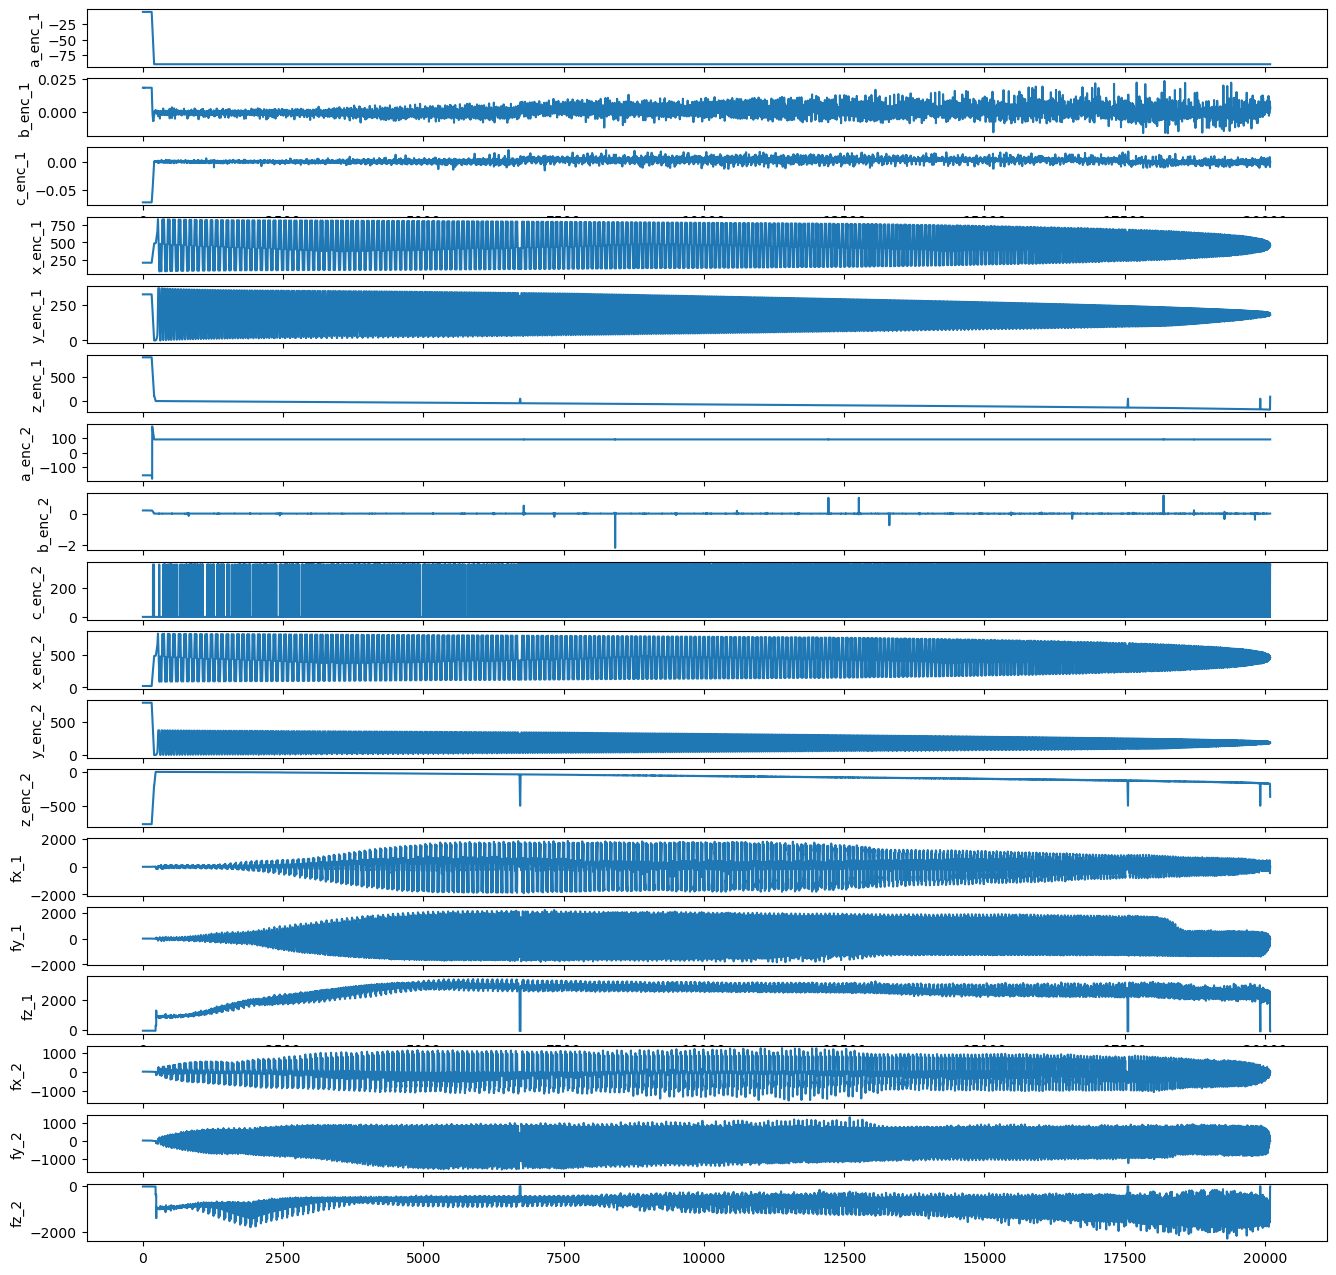

In [47]:
make_time_series_plots()
plt.show()

These plots show a few things:

 - 1 The data has some startup time characterized by what looks like the arms moving into position. During this transient period, the motion of the arms is not correlated with the forces since they are freely moving without making contact with the sheet. Clearly this data should not ulimately used for training
 - 2 There are anamolies. The data shows spikes across many variables at specific times. We should investigate these before applying any learning.
 - 3 There are apparent oscillations. It's difficult to tell from the wide time range, but many variables appear to show oscillations.
 
 To investigate 2 and 3, let's look at what happens over a zoomed in time window. In particular, (6k-7k) since it contains a large spike in the data.

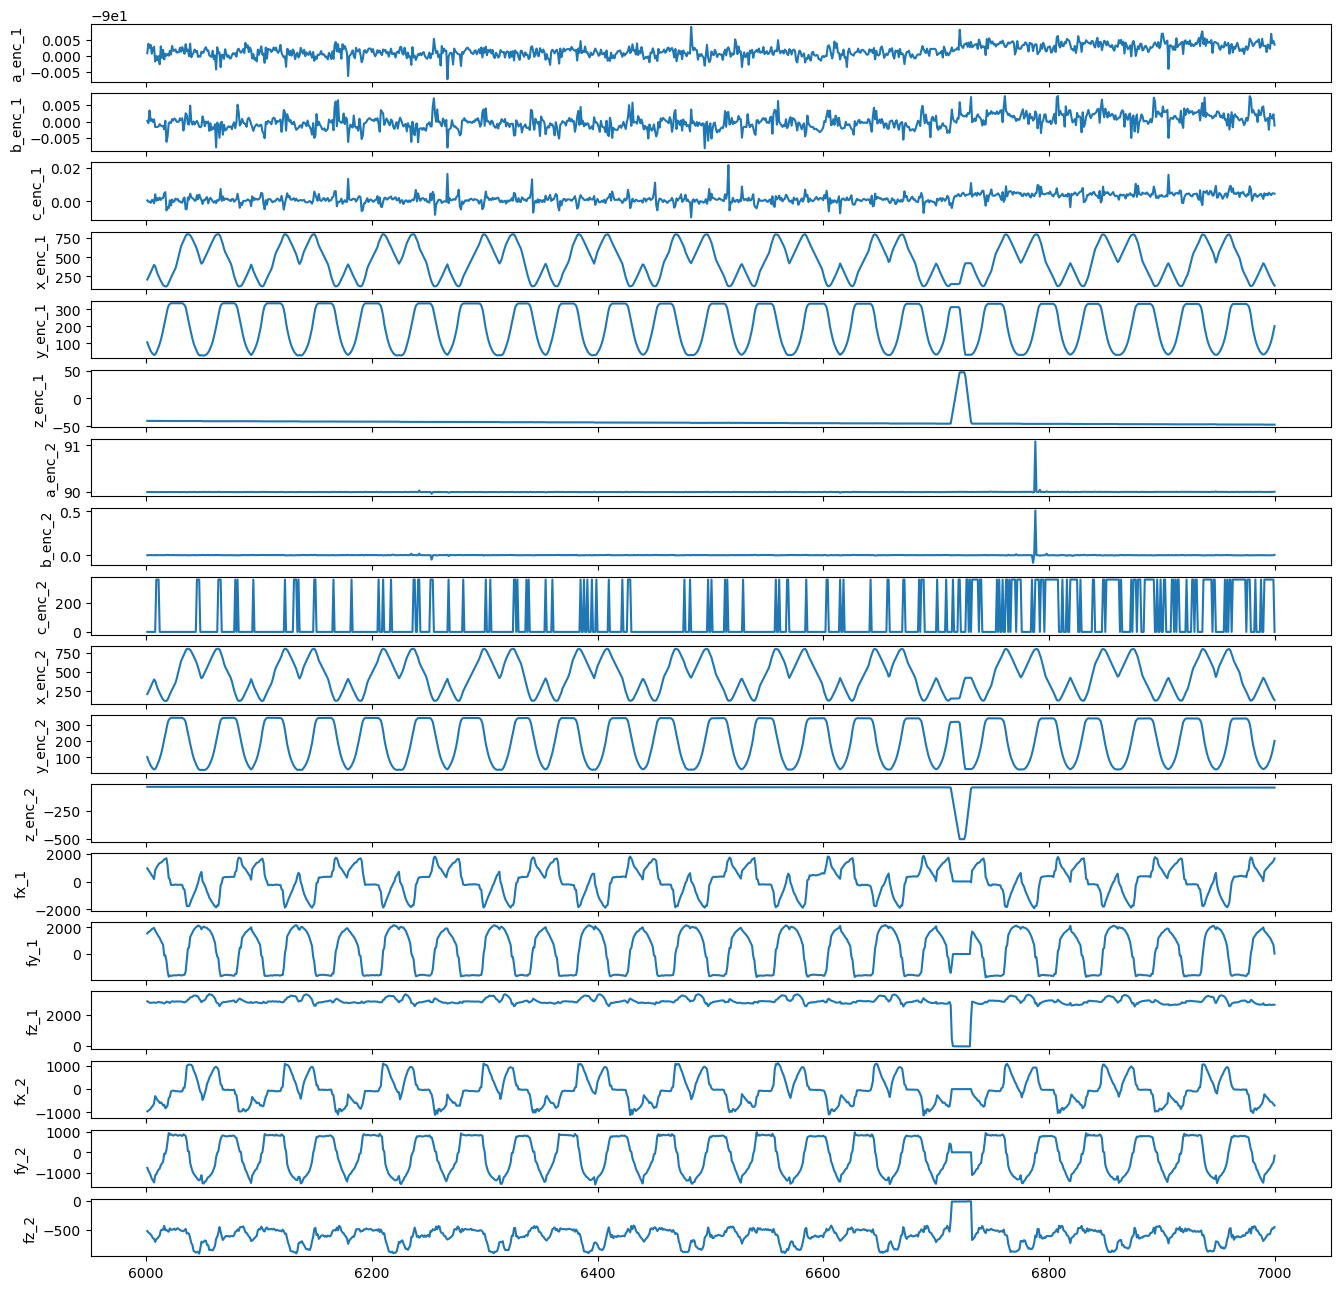

In [45]:
make_time_series_plots(time_range=(6000, 7000))

Here we can see there are a few "anamolies" in the data

1. At around 6700, the z position of R1 and R2 move away from each other. Correspondingly the forces go to zero. Since this can be predicted from the data. We may leave these in for now.
2. At around 6800, the a and b angles of R2 spike. However, it's relatively small (~2 degrees).
3. The c angle of R2 constantly spikes between its min and max. This appears to be a representation issue: the angle isn't changing by much, it's just moving between ~180 and ~181, which are both represented by 180, -179. This issue we may be able to fix by changing the representation from [-pi, pi] to [0, 2 pi]. Though this may introduce other problems if the angle goes near zero.

**Next Step** Reparametrize c and look at full data to see if that removes its anamolies:

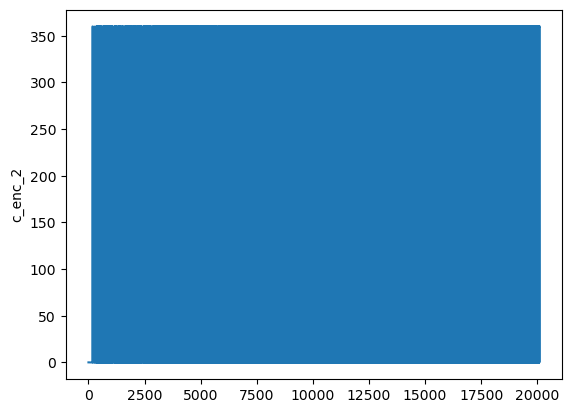

In [38]:
d1.c_enc_2 = (d1.c_enc_2 + 180) % (360)
make_time_series_plots(columns=['c_enc_2'], figsize=None)

### The Angle Problem
The above plot shows that the c angle spans the full angle range. No parametrization of c will prevent discontinuities. Therefore, it makes sense to represent the c angle in terms of sin(c), cos(c) since these are guaranteed to be continuous.

### Position and Forces
Let's look more closely at how the position and force data behaves to make sure there are no other obvious forms of data preparation we should do.

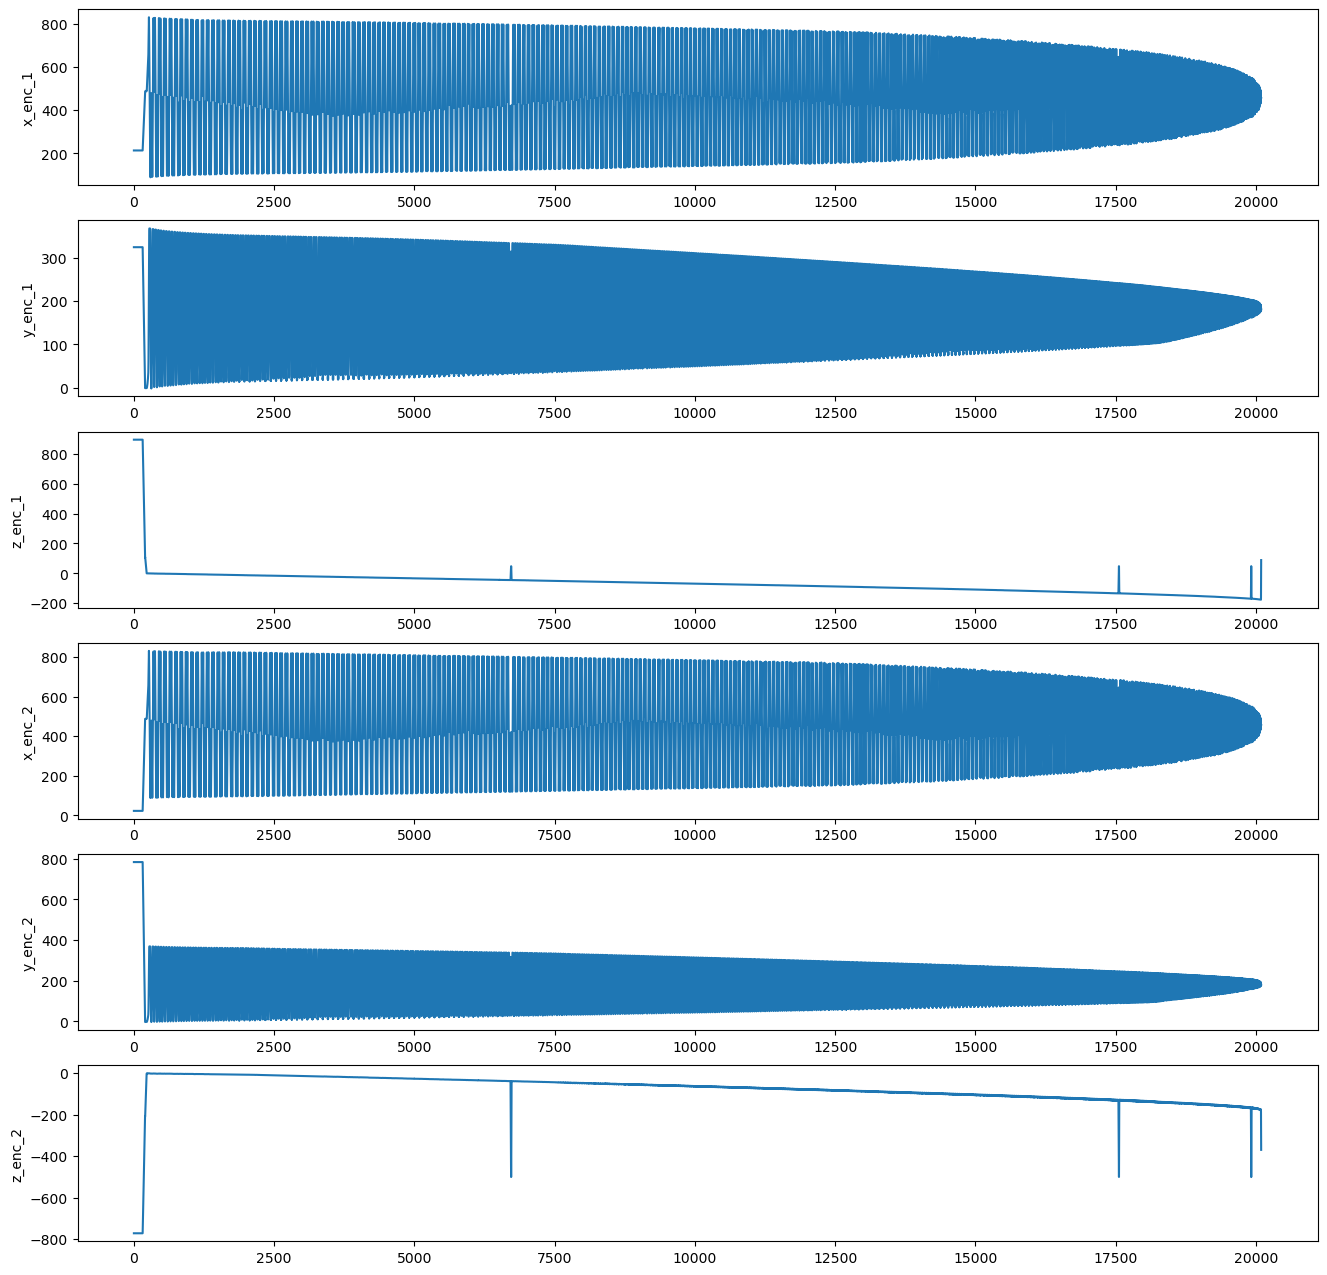

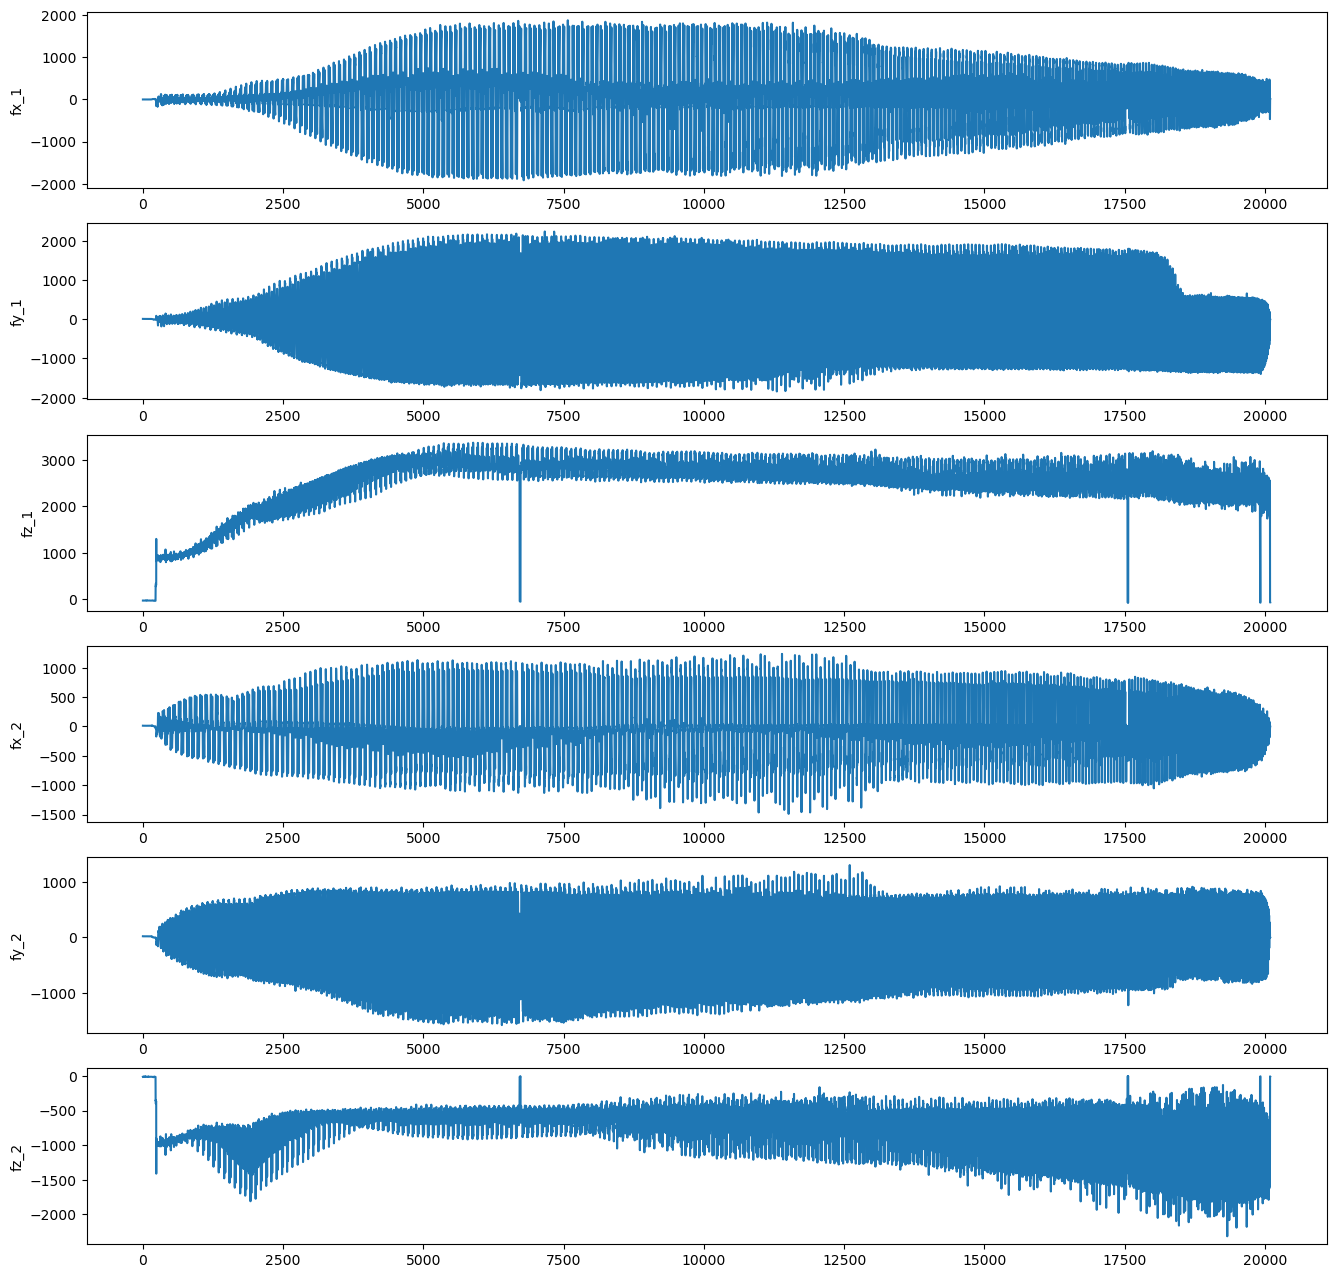

In [42]:
make_time_series_plots(columns=['x_enc_1', 'y_enc_1', 'z_enc_1', 'x_enc_2', 'y_enc_2', 'z_enc_2'])
make_time_series_plots(columns=['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'])

The only features which jump out here are the ones noted before: When the z position of R1 and R2 move away from each other, all the forces go to zero. It also disrupts the oscillations in x and y. Therefore, we can hypothesize that these osillations are caused by contact with the sheets. For now, however, these appear to be learnable anamolies. As a first pass we can include them in the data. If we find that it gives us problems, we can restrict the data to periods without these spikes

## Summary of Conclusions from Data Visualization

To summarize what has been learned so far:
 - 1. **Transient Times** Datasets have an initial transient period where arms are moving into position. These should be removed from the dataset since the motion of the arms is not correlated with the forces during this time (since the forces are all zero)
 - 2. **Angle Representations** The datasets contain angle data which can be problematic because of fake-discontinuties occuring as the angle moves from e.g. 180 to 181. The only column that I noticed had this problem explicitly was `c_enc_2`, but it might be good practice to handle all the angle data similarly. My initial idea for how to do this is to split `c_enc_2` (and the others) into two columns: `c_cos_2`, `c_sin_2`, which will remove the apparent discontinuities.
 - 3. **Lost Contact** The datasets contain spikes when the robots lose contact with the sheet. This is when R1 and R2 move away from each other in the z-direction. This causes all the forces to go to zero and the oscillations in x and y to ceases. For now, we will include this in the dataset since these are learnable features. If it causes problems, we may need to remove these.
 
### Other steps that could be taken
In the interest of time, I have only taken a quick pass at data inspection. In a professional context, I would do more. Specifically I would:
 - Visually analyze the data for the other input files
 - Perform a more thorough inspection of anomalies
   - At a minimum I would look at zoomed in plots for each column and see if there are any other anomalies which don't fit into the previously mentioned categories. 
   - I would also probably make plots of the derivatives for each column and look for spikes.
   - We could also run anomaly detection algorithms to be even more thorough.
   - After cleaning the data of all of the anomalies I found. I would then make a histogram of the derivative of each column and look for outliers. If any are found, then there are probably anomaly cases that I have not yet cleaned.


# The Dataset class <span id="dataset"></span>
Based on the above, we define the following dataset class to load our data. This is a messy first pass.

It's fairly straightforward. We highlight the relevant features:
 1. It reads the CSV file and then returns subsequences of input/label data of `sequence_length`
 2. It removes the initial 500 points of data (more sophisticated methods could be used to dynamically determined this)
 3. It splits each angle column into two columns giving the sine and cosine
 4. It normalizes the input data columns by mean and standard deviation
 5. It normalizes the label columns (the forces) by a predetermined range. This keeps the MSE in a reasonable range. It's important that we perform this normalization using fixed values since we won't have access to the mean/standard deviation when training on new test data.

In [105]:
import itertools
import pandas as pd
import torch

# Number of features in label (number of forces)
NUM_OUT = 6

# Number of features in processed input
NUM_INPUT = 2 * (3 + 6)

# Predetermined values to normalize the forces by
FX_RANGE = [-2500, 2500]
FY_RANGE = [-2500, 2500]
FZ_RANGE1 = [-100, 3500]
FZ_RANGE2 = [-2500, 100]

class CDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file, sequence_length, transient_time=500):
        super().__init__()
        self.sequence_length = sequence_length
        self.transient_time = transient_time

        dataframe = pd.read_csv(csv_file)[transient_time:]
        self.dataframe = dataframe # only for testing, in real data, use more efficient resource management

        def seq_to_tensor(pd_seq):
            return torch.from_numpy(pd_seq.values).float()

        self._data_y = torch.empty(len(dataframe), NUM_OUT)
        self._data_x = torch.empty(len(dataframe), NUM_INPUT)
        self._times = seq_to_tensor(dataframe.t)

        # Generate column names so we can handle different types separately.
        force_cols = ['f%s_%d' % p for p in itertools.product(['x', 'y', 'z'], [1, 2])]
        pos_cols = ['%s_enc_%d' % p for p in itertools.product(['x', 'y', 'z'], [1, 2])]
        ang_cols = ['%s_enc_%d' % p for p in itertools.product(['a', 'b', 'c'], [1, 2])]

        # Load forces into y data
        for i, force_col in enumerate(force_cols):
            self._data_y[:,i] = seq_to_tensor(getattr(dataframe, force_col))

        # Load x/y/z positions into x data
        for i, pos_col in enumerate(pos_cols):
            self._data_x[:,i] = seq_to_tensor(getattr(dataframe, pos_col))

        # For each angle, generate two columns, one for sine and one for cosine.
        for i, ang_col in enumerate(ang_cols):
            self._data_x[:,2*i + 6] = torch.sin(seq_to_tensor(getattr(dataframe, ang_col)))
            self._data_x[:,2*i + 7] = torch.cos(seq_to_tensor(getattr(dataframe, ang_col)))

        self._times = self._times - self._times[0]
        self._normalize_x_data()
        self._normalize_y_data()

    def _normalize_x_data(self):
        # Normalize all inputs by their standard deviation and mean
        for i in range(NUM_INPUT):
            mean = torch.mean(self._data_x[:,i])
            std = torch.std(self._data_x[:,i])
            self._data_x[:,i] = (self._data_x[:,i] - mean) / std

    def _normalize_y_data(self):
        """
        We can't use the y values to normalize the y data because this is cheating! Instead we should
        rescale the force values by some pre-determined minimum/maximum range that is context specific.
        Here I've chosen fixed values based on the three input files.
        """
        for i in [0, 1]:
            self._data_y[:,i] = (self._data_y[:,i] - FX_RANGE[0]) / (FX_RANGE[1] - FX_RANGE[0])
        for i in [2, 3]:
            self._data_y[:,i] = (self._data_y[:,i] - FY_RANGE[0]) / (FY_RANGE[1] - FY_RANGE[0])
        self._data_y[:,4] = (self._data_y[:,4] - FZ_RANGE1[0]) / (FZ_RANGE1[1] - FZ_RANGE1[0])
        self._data_y[:,5] = (self._data_y[:,5] - FZ_RANGE2[0]) / (FZ_RANGE2[1] - FZ_RANGE2[0])

    def __len__(self):
        return len(self._data_y) - self.sequence_length

    def __getitem__(self, i):
        i2 = i + self.sequence_length
        return self._data_x[i:i2], self._data_y[i:i2], self._times[i:i2]

    def get_n_inputs(self):
        return self._data_x.shape[1]

    def get_n_outputs(self):
        return self._data_y.shape[1]

# The Metric <span id="metric"></span>
The problem statement asks to predict the value of the force sensors. I can see two possible interpretations of this:

  1. Given a local time series x1, ..., xn and force values f1,.., f_(n-1), predict the value of fn. Meaning that the prediction has access to the force value from the previous time step and the current sensor data and wants to know the force. Alternatively you could predict f_(n+1) from (x1,...,xn) and (f1,...,fn)
  2. Given a time series x1,...,xn, determine the likely corresponding force values f1,...,fn

The first is useful for real-time protocol adjustments. In real-time, the machine has access to its sensor data and it could use this to predict what the most likely force value will be and change its protocol accordingly. The second is useful for protocol design.

I am interpretting the problem to be the latter: predict the value of the force at time t without any information about previous forces. For this, the obvious metric of a predictor is the MSE. Specifically, let `M` be a model which maps a time-series `X=(x1,...,xn)` to force values `(f1,...,fn)`. Then the metric of our model is the MSE between its prediction and the actual forces

  Loss(X, M) = (1/n)\sum_{i=1}^n (f_i - M(X)_i)^2

This will be incorporated into the training via the usual mini-batching process.

# The Model <span id="model"></span>
Since this is time-series data, its most appropriate to use an RNN or a transformer model. Here I've decided to use an LSTM based RNN with some fully connected layers.

The model takes a subsequence of sensor data and makes a prediction about the force at the latest timestep. The choice of what subsequence length to use when training our model is a hyperparameter.

In [51]:
import torch
import torch.nn as nn

class LSTM2(nn.Module):
    """
    This is an LSTM cell based model. It has one LTSM cell with a tunable number of layers and hidden features.
    After the LSTM cell, there are two fully-connected layers with ReLU activations and possible dropout applied.
    """

    def __init__(self, num_input_features, num_output_features, num_layers=5, num_hidden=12, dtype=torch.float, dropout=0.0):
        super().__init__()
        self.dtype = dtype
        self.num_layers = num_layers
        self.num_output_features = num_output_features
        self.num_input_features = num_input_features
        self.num_hidden = num_hidden
        self.lstm = nn.LSTM(num_input_features, num_hidden, num_layers, batch_first=True, dtype=dtype)
        self.fc_1 = nn.Linear(num_layers * num_hidden, 128, dtype=dtype)
        self.fc = nn.Linear(128, num_output_features, dtype=dtype)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # initialize hidden layer and cell to zeros. Given more time, alterative
        # methods for weight initialization could be explored.
        h_0 = torch.zeros(self.num_layers, x.size(0), self.num_hidden, dtype=self.dtype)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.num_hidden, dtype=self.dtype)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        # Flatten the last layer of the output
        out = output.contiguous()[:,-self.num_layers:,:].view(-1, self.num_hidden * self.num_layers)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out



# Training <span id="training"></span>
## Train/Test/Validate Strategies
The main idea is to train the model by feeding it sequences of the input data pulled from the CSV files. There is a bit of a philisophical issue with how to assign training and test data with regards to the three files.

Put simply, how should we split our training/testing/validation data? Should each one come from different CSV files, or should all three be a mix of sequences pulled from each?

Without understanding the underlying process that generates the three files, we do not know whether we can consider sequences pulled from each one as being representative of the others. Put another way, the individual runs may not be doing the same things, and so there may be a limit to one's predictive power on the other.

For the sake of time and simplicity, I have decided to use `Test1.csv` as the training data set, `Test2.csv` as the validation set, and `Test4.csv` as a testing data set. One could argue that the assumption that they have the same statistics is flawed. That may be the case. But if that's true, then it's unlikely that those three files span the full range of processes so our data is incomplete anyway.

## Training code
Given this, the training code I used was the following:

Epoch  1 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:      0.00234

Running training: ltsm2


Epoch  1 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     0.000533


Train MSE: 0.000533


Epoch  2 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:     0.000214

Test  MSE: 0.000226


Epoch  2 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:      0.00015


Train MSE: 0.000150


Epoch  3 / 20 |   5%|              |  ETA:   0:00:03 | epoch_loss:     0.000107

Test  MSE: 0.000087


Epoch  3 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     8.59e-05


Train MSE: 0.000086


Epoch  4 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     8.36e-05

Test  MSE: 0.000082


Epoch  4 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     6.64e-05


Train MSE: 0.000066


Epoch  5 / 20 |   5%|              |  ETA:   0:00:03 | epoch_loss:      5.8e-05

Test  MSE: 0.000080


Epoch  5 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     5.85e-05


Train MSE: 0.000058


Epoch  6 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:        6e-05

Test  MSE: 0.000072


Epoch  6 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     5.18e-05


Train MSE: 0.000052


Epoch  7 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     5.26e-05

Test  MSE: 0.000071


Epoch  7 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     5.16e-05


Train MSE: 0.000052


Epoch  8 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     5.07e-05

Test  MSE: 0.000079


Epoch  8 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.97e-05


Train MSE: 0.000050


Epoch  9 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     4.87e-05

Test  MSE: 0.000066


Epoch  9 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.69e-05


Train MSE: 0.000047


Epoch 10 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     4.89e-05

Test  MSE: 0.000081


Epoch 10 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.61e-05


Train MSE: 0.000046


Epoch 11 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     4.55e-05

Test  MSE: 0.000071


Epoch 11 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.41e-05


Train MSE: 0.000044


Epoch 12 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:      3.9e-05

Test  MSE: 0.000071


Epoch 12 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:      4.4e-05


Train MSE: 0.000044


Epoch 13 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:     4.85e-05

Test  MSE: 0.000066


Epoch 13 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.34e-05


Train MSE: 0.000043


Epoch 14 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:     4.14e-05

Test  MSE: 0.000076


Epoch 14 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.03e-05


Train MSE: 0.000040


Epoch 15 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     3.92e-05

Test  MSE: 0.000067


Epoch 15 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.18e-05


Train MSE: 0.000042


Epoch 16 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:        5e-05

Test  MSE: 0.000061


Epoch 16 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     4.05e-05


Train MSE: 0.000040


Epoch 17 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     4.28e-05

Test  MSE: 0.000066


Epoch 17 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     3.93e-05


Train MSE: 0.000039


Epoch 18 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:     3.63e-05

Test  MSE: 0.000069


Epoch 18 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     3.93e-05


Train MSE: 0.000039


Epoch 19 / 20 |   4%|              |  ETA:   0:00:03 | epoch_loss:     3.78e-05

Test  MSE: 0.000061


Epoch 19 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     3.84e-05


Train MSE: 0.000038


Epoch 20 / 20 |   4%|              |  ETA:   0:00:04 | epoch_loss:     3.97e-05

Test  MSE: 0.000070


Epoch 20 / 20 | 100%|##############|  Time:  0:00:04 | epoch_loss:     3.98e-05


Train MSE: 0.000040
Test  MSE: 0.000078


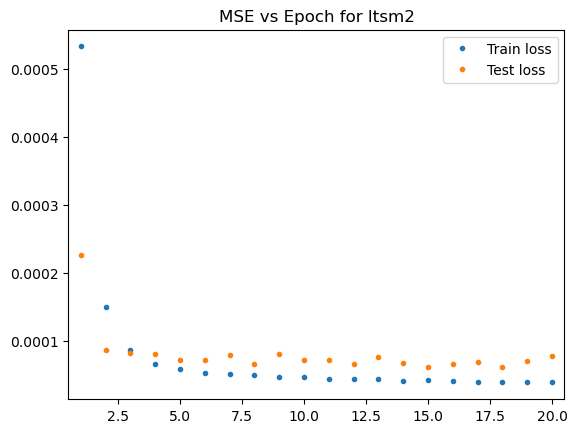

In [60]:
import progressbar
import os
from torch.utils.data import DataLoader

SEQ_LENGTH = 8
BATCH_SIZE = 32
N_EPOCHS = 20
LR = 0.005
NAME = 'ltsm2'
OUTPUT_DIR = 'outputs'
DROPOUT = 0.2
TRAIN_FILE = 'Test1.csv'
TEST_FILE = 'Test2.csv'

def go(name=NAME, seq_length=SEQ_LENGTH, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, dropout=DROPOUT, lr=LR):
    ds_train = CDataset('Test1.csv', seq_length)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    ds_test = CDataset('Test2.csv', seq_length)
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
    loss_fn = nn.MSELoss()
    model = LSTM2(ds_train.get_n_inputs(), ds_train.get_n_outputs(), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print('Running training: %s' % name)
    train_losses, test_losses = train(dl_train, model, optimizer, loss_fn, n_epochs, test_dataloader=dl_test)
    save_results(name, model, train_losses, test_losses)

def train(dataloader, model, optimizer, loss_fn, n_epochs, test_dataloader=None):
    loss_tr = np.zeros(n_epochs)
    loss_ts = np.zeros(n_epochs)
    for i in range(n_epochs):
        loss = train_step(i, n_epochs, dataloader, model, optimizer, loss_fn)
        loss_tr[i] = loss
        print('Train MSE: %f' % loss)
        if test_dataloader:
          loss = test(test_dataloader, model, loss_fn)
          loss_ts[i] = loss
          print('Test  MSE: %f' % loss)
    if test_dataloader:
        return loss_tr, loss_ts
    else:
        return loss_tr

def test(dataloader, model, loss_fn):
    model.eval()
    count = 0
    total_loss = 0.0
    with torch.no_grad():
        for i, (x, y, _) in enumerate(dataloader):
            x, y = x.to('cpu'), y.to('cpu')
            pred = model(x)
            total_loss += loss_fn(pred, y[:,-1,:]).item()
            count += len(x)
    return total_loss / count

def train_step(epoch_idx, n_epochs, dataloader, model, optimizer, loss_fn):
    model.train()
    count = 0
    total_loss = 0.0
    with get_prog_bar(epoch_idx, n_epochs, len(dataloader)) as bar:
        bar.update(0, epoch_loss=0)
        for i, (x, y, _) in enumerate(dataloader):
            x, y = x.to('cpu'), y.to('cpu')
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y[:,-1,:])
            loss.backward()
            optimizer.step()
            count += len(x)
            total_loss += loss.item()
            bar.update(i + 1, epoch_loss=(total_loss / count))
    return total_loss / count

def get_prog_bar(epoch_idx, n_epochs, n_batches):
    widgets = [
        'Epoch %2d / %2d | ' % (epoch_idx + 1, n_epochs),
        progressbar.Percentage(),
        progressbar.Bar(),
        '  ',
        progressbar.ETA(),
        ' | ',
        progressbar.Variable('epoch_loss', precision=3, width=12),
    ]
    return progressbar.ProgressBar(max_value=n_batches, widgets=widgets)

def save_results(name, model, train_losses, test_losses):
    output_dir = os.path.join(OUTPUT_DIR, name)

    # Make plot of MSE vs epoch for train and test data
    fig, ax = plt.subplots()
    n_epochs = len(train_losses)
    x = list(range(1, n_epochs + 1))
    ax.set_xlim(0.5, n_epochs + 0.5)
    ax.plot(x, train_losses, '.', label='Train loss')
    ax.plot(x, test_losses, '.', label='Test loss')
    ax.set_title('MSE vs Epoch for %s' % name)
    ax.legend()

    make_dir(output_dir)
    fig.savefig(os.path.join(output_dir, 'mse-vs-time.png'))

    # Save model state
    model_file = os.path.join(output_dir, 'model.pt')
    torch.save(model.state_dict(), model_file)

def make_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)
    return d
go()

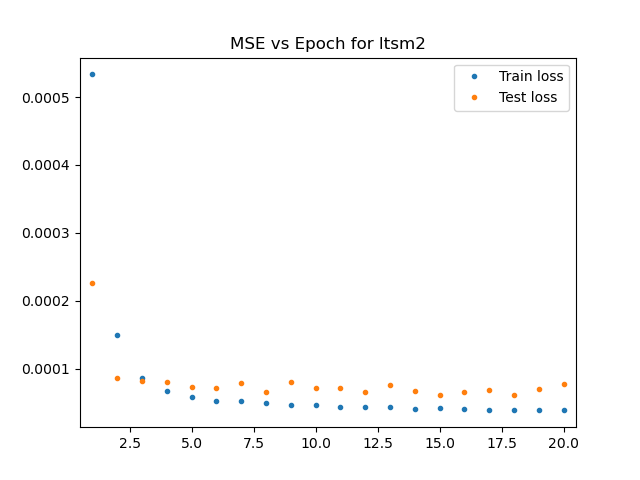

In [61]:
display(Image('outputs/%s/mse-vs-time.png' % NAME))

## Training comments

### Hyperparameters

 - There are several hyperparameters here: the learning rate, the sequence size, batch size, the model architecture, the number of hidden layers, number of hidden features, the dropout rate, and many others
 - The values given here were the best of a few manually tweaked values. In a real setting, I would set up a systematic approach to iterating over hyperparamers and checking the validation set.
 - Here we used `Adam` as the optimizer. In my experience, Adam is a good first-pass optimizer because it's hyperparameters are easily tuned to "good enough". In a more refined context, I would use SGD with momentum and a learning rate schedule.

### Generalization

 - The generalization error seems reasonable. In many overfitted models, once the overfitting occurs, the test error begins to rise. Here after running for 20 epochs, we see that there is a generalization gap, but it appears stable.
 - This model seems a reasonable first pass approach. We can get a sense of what these MSE values mean by creating prediction plots (see below)

 
# Visualizing predictions <span id="visualizing"></span>
As a sanity check that these MSE values were acceptable, I wrote code that plots the predicted force values for a trained model.

In [107]:
class PathGen():

    def __init__(self, dataset, model, outdir, use_existing=False):
        self.outdir = outdir
        self.dataset = dataset
        self.model = model
        self.ys_file = os.path.join(self.outdir, 'ys.pt')
        self.ts_file = os.path.join(self.outdir, 'ts.pt')
        self.ys_act_file = os.path.join(self.outdir, 'ys_act.pt')
        if use_existing:
            self.load_files()
        if not hasattr(self, 'ts'):
            self.generate_data()

    def generate_plots(self, i1, i2, y_indices=None, save=True):
        y_indices = y_indices or range(self.dataset.get_n_outputs())
        for i in y_indices:
            plt.clf()
            fname = os.path.join(self.outdir, 'y-%d.png' % i)
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            ax.set_ylim(-0.05, 1.05)
            ax.plot(self.ts[i1:i2], self.ys[i1:i2,i], label='Pred data')
            ax.plot(self.ts[i1:i2], self.ys_act[i1:i2,i], label='Real data')
            ax.legend()
            if save:
                fig.savefig(fname)
                plt.close(fig)

    def load_files(self):
        if os.path.exists(self.ts_file):
            self.ts = torch.load(self.ts_file)
            self.ys = torch.load(self.ys_file)
            self.ys_act = torch.load(self.ys_act_file)

    def save_files(self):
        torch.save(self.ts, self.ts_file)
        torch.save(self.ys, self.ys_file)
        torch.save(self.ys_act, self.ys_act_file)

    def generate_data(self):
        self.model.eval()
        with torch.no_grad():
            self.ts = torch.empty(len(ds), dtype=torch.int64)
            self.ys = torch.empty(len(ds), self.dataset.get_n_outputs())
            self.ys_act = torch.empty(len(ds), self.dataset.get_n_outputs())
            for i in progressbar.progressbar(range(len(ds))):
                x, y_act, t = ds[i]
                y = model(x[None,:])
                self.ts[i] = t[-1]
                self.ys[i] = y[0]
                self.ys_act[i] = y_act[-1]
        self.save_files()

# Plot predicted vs actual forces for Test4.csv which we've never looked at yet
ds = CDataset('Test4.csv', SEQ_LENGTH)
model = LSTM2(ds.get_n_inputs(), ds.get_n_outputs())
model.load_state_dict(torch.load('outputs/ltsm2/model.pt'))

pg = PathGen(ds, model, 'outputs/ltsm2', use_existing=True)
pg.generate_plots(10000, 11000)

<Figure size 640x480 with 0 Axes>

## Reconstructed force diagrams
After all that, let's see how our model does:

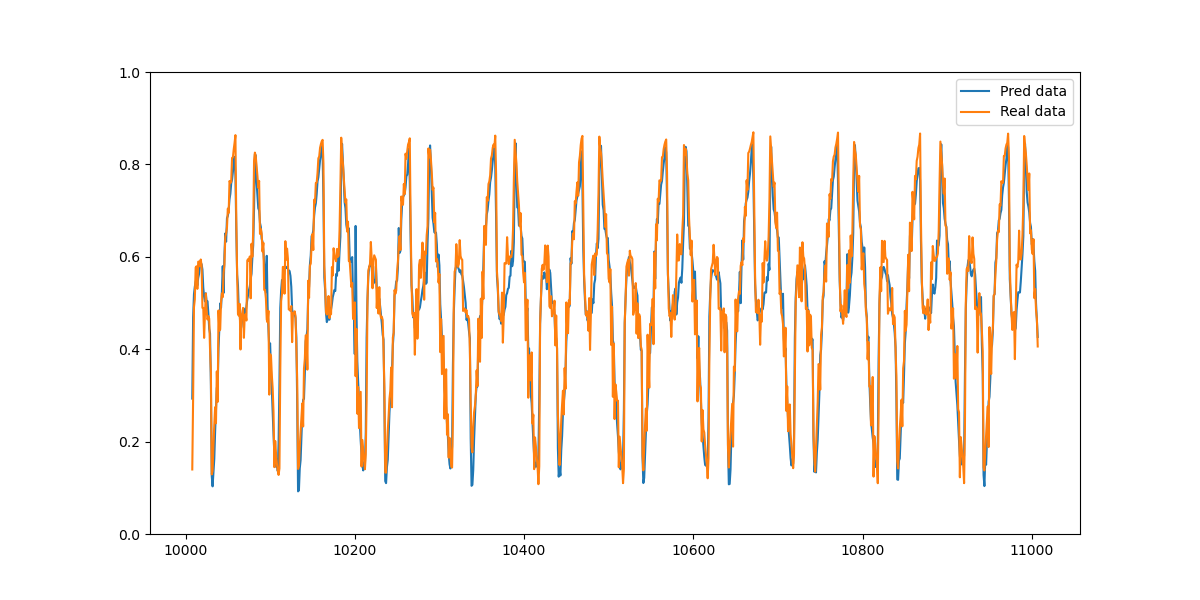

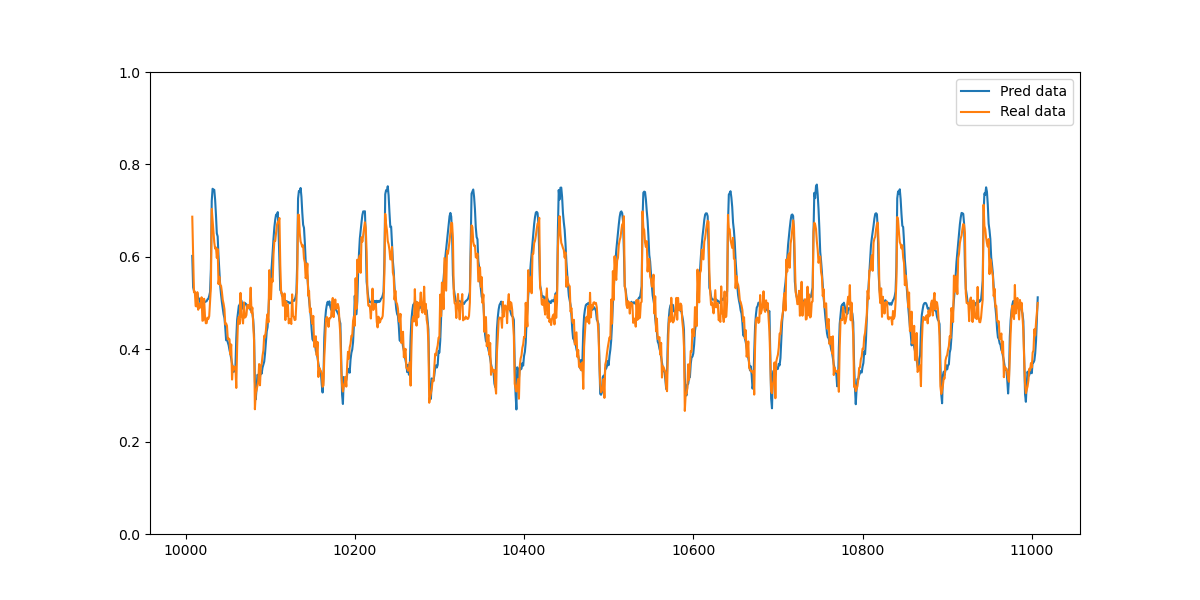

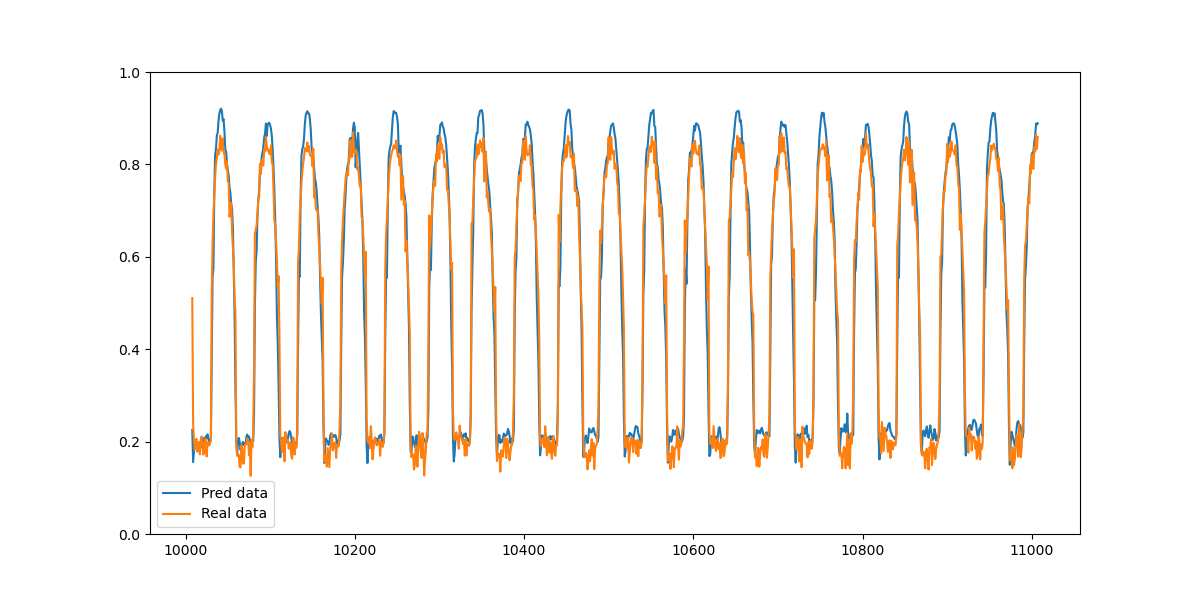

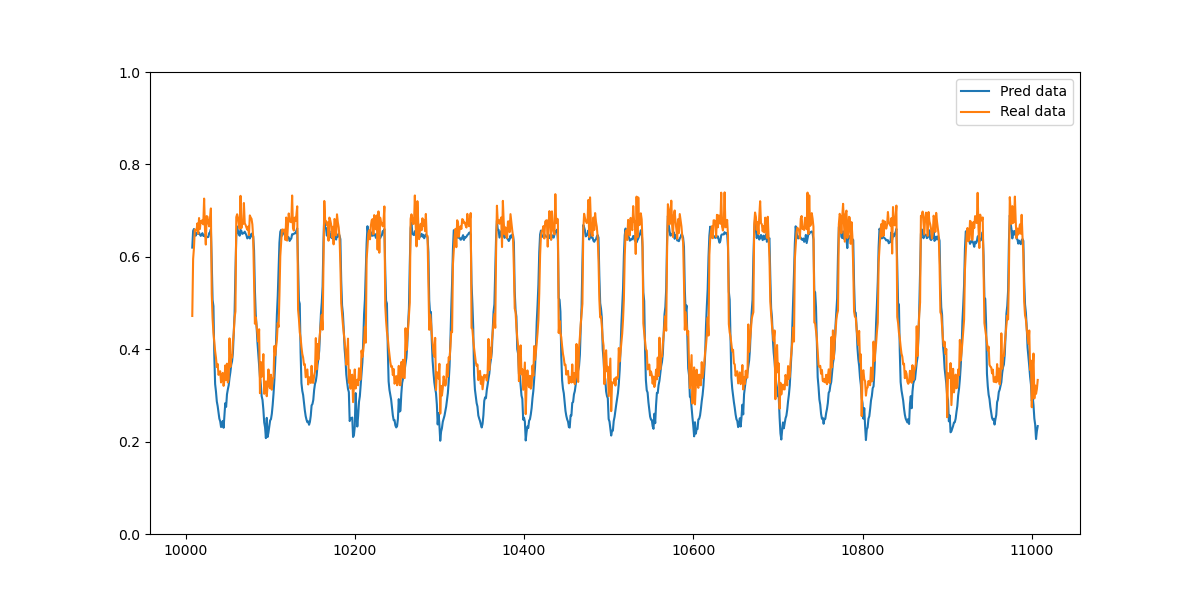

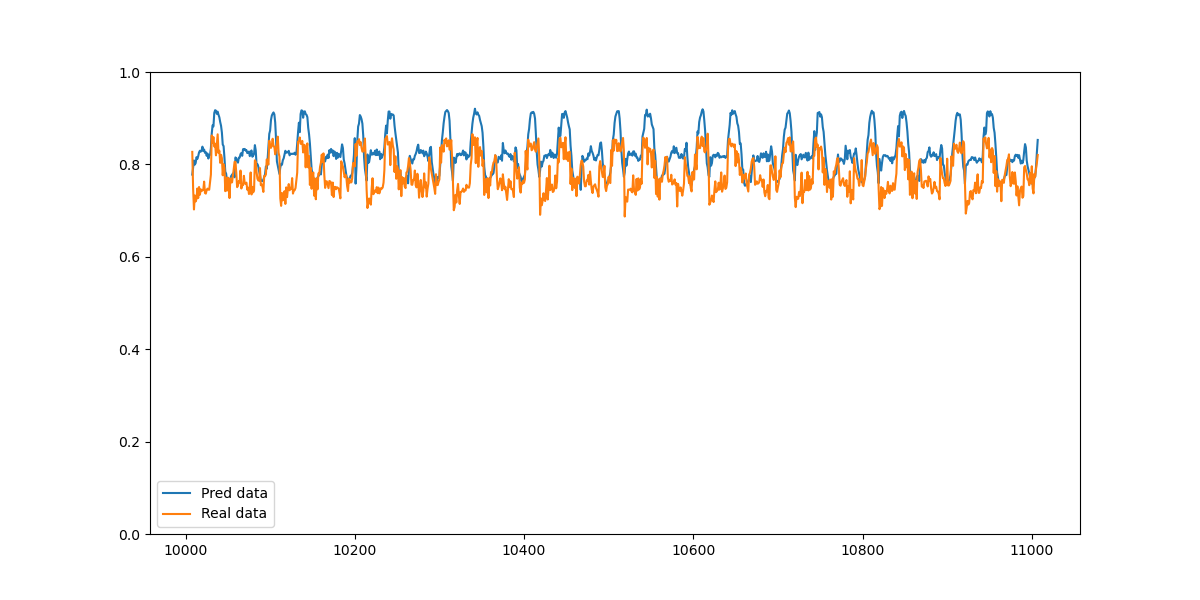

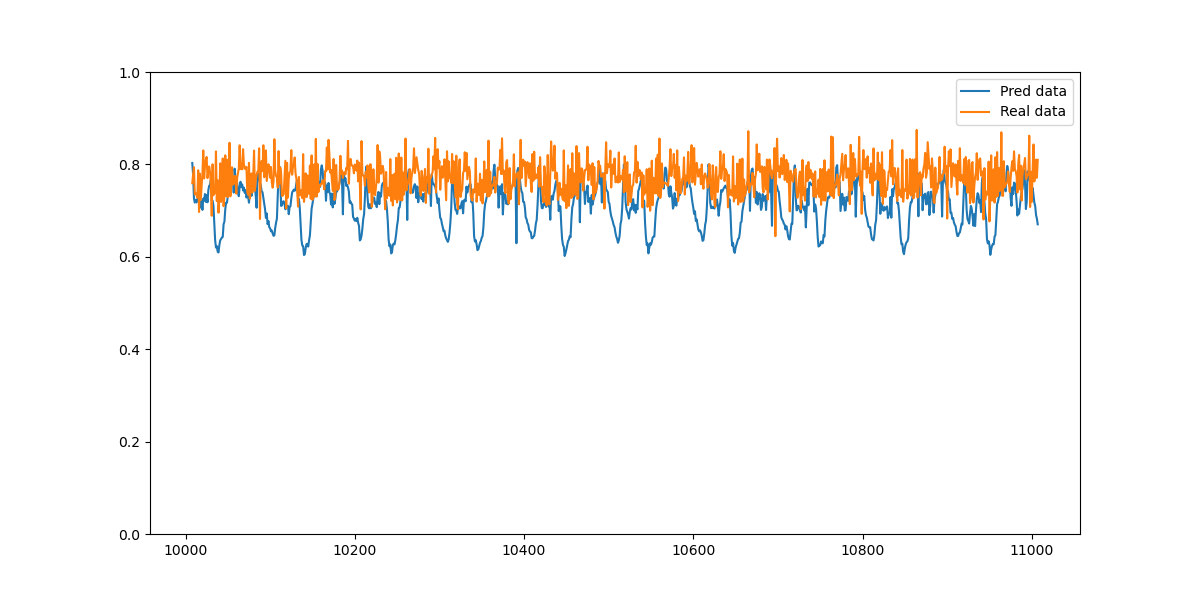

In [90]:
display(Image('outputs/ltsm2/y-0.png'))
display(Image('outputs/ltsm2/y-1.png'))
display(Image('outputs/ltsm2/y-2.png'))
display(Image('outputs/ltsm2/y-3.png'))
display(Image('outputs/ltsm2/y-4.png'))
display(Image('outputs/ltsm2/y-5.png'))

From the above, we see that y 0-3 have very good prediction/actual agreement. These correspond to the x forces on robot 1 and 2, and the y forces on robot 1 and 2.

However, y4 and y5 are more suspect. These are the z-forces. One reason for this is that the data is inherently noisier for the z forces. It is also the case that the local-variance of the z forces is quite small. To see this, let's return to our time-series visualization.

The x forces vary somewhat uniformly across the whole time-series:

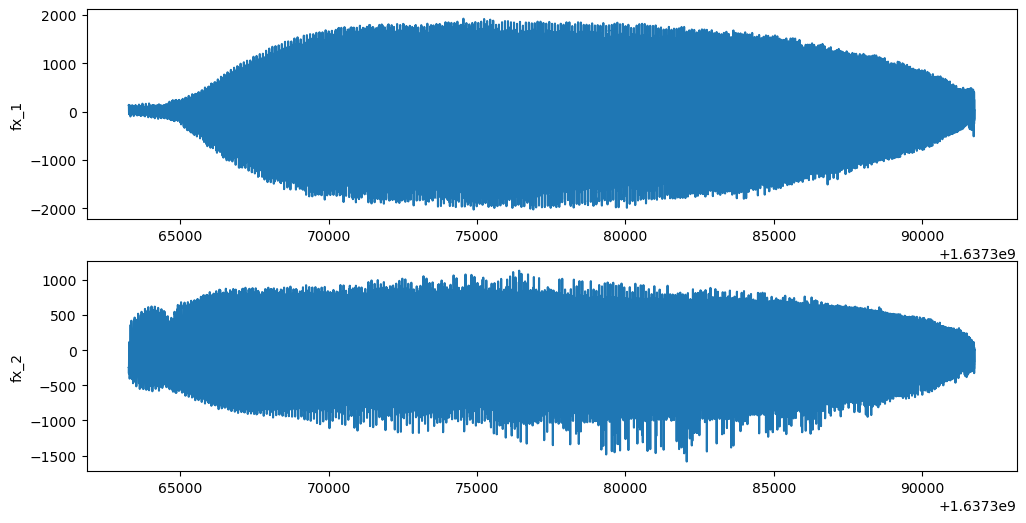

In [108]:
make_time_series_plots(d=ds.dataframe, columns=['fx_1', 'fx_2'], figsize=(12, 6))

But the z forces time-series tends to have a low variance over local patches of the time-series:

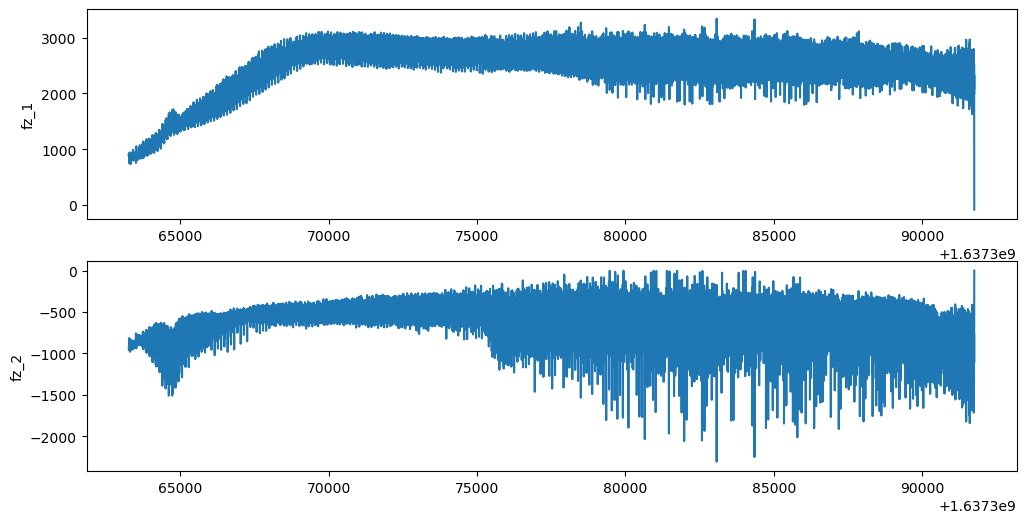

In [109]:
make_time_series_plots(d=ds.dataframe, columns=['fz_1', 'fz_2'], figsize=(12, 6))

Our model could certainly be improved. But it does give an accurate prediction for the x and y forces, and a somewhat accurate prediction for z. To see this, let's look at the predictions over a longer timeframe:

<Figure size 640x480 with 0 Axes>

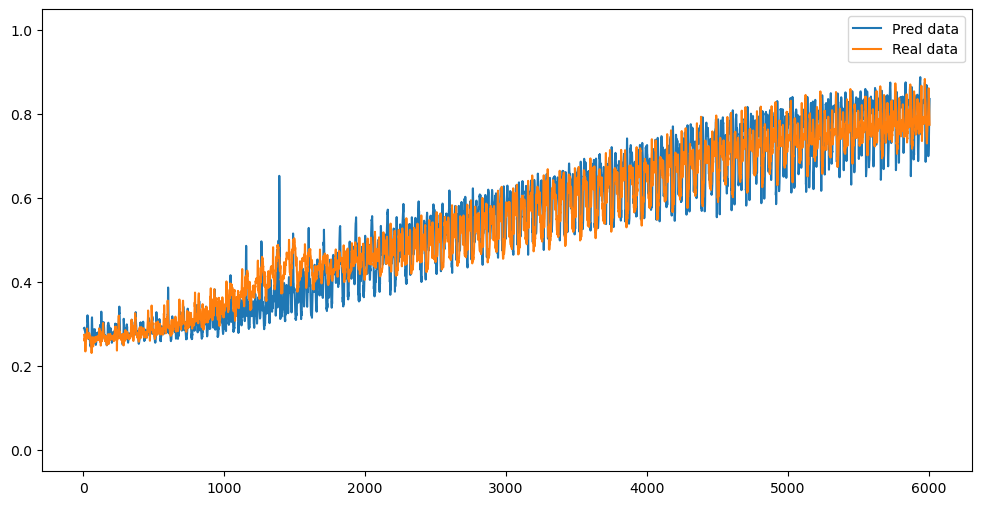

In [110]:
pg = PathGen(ds, model, 'outputs/ltsm2', use_existing=True)
pg.generate_plots(0, 6000, [4], save=False)

# Conculsions  <span id="conclusions"></span>

The work shown here is a first-pass approach. In a real environment, there are many additions and experiments that would be layered in. There are obvious things missing:
 - Running jobs to search hyperparameter space on validation set
 - Regularization. I didn't add this because the generalization error seemed okay for a quick assignment
 - Autostopping
 - Anomaly detection

In addition to the basics, there are some specific things I would do to improve the model.

## Weighted metric
Without knowing details about the company's technology, I suspect that the z-component of the force is important. The model appeared to learn the x and y components quickly, but struggled more to understand the z component. One thing I would experiment with is a weighted metric that gives more importantance to the z component than the other two

## Using linear regression to remove instantaneous correlations
There is an obvious long-term correlation between the variables which is often obscured by local effects like oscillations. The use of an LTSM model is meant to capture elements of the model that are history dependent. We may be able to improve it's behavior by decorrelating the long term trends.

One basic idea would be to run a linear regression which predicts the forces at time `t` given the input variables at time `t`. We can then subtract from the actual force at time `t`, the value predicted by the linear regression. This would remove the instantaneous linear correlations in the data, leaving the more advanced RNN model to try to understand time-structured features.


## Transformers
The world of time-series deep learning is fairly new to me. I know that LTSMs were very popular a few years ago, but they have been largely supplanted by transformer models. This is something I would investigate here.